In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json here

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c statoil-iceberg-classifier-challenge -p /content/

 59% 169M/288M [00:00<00:00, 1.76GB/s]
100% 288M/288M [00:00<00:00, 1.79GB/s]


In [ ]:
!unzip /content/statoil-iceberg-classifier-challenge.zip -d /content/iceberg_data

Archive:  /content/statoil-iceberg-classifier-challenge.zip
  inflating: /content/iceberg_data/sample_submission.csv.7z  
  inflating: /content/iceberg_data/test.json.7z  
  inflating: /content/iceberg_data/train.json.7z  


In [ ]:
!apt-get install -y p7zip-full
!7z x /content/iceberg_data/train.json.7z -o/content/iceberg_data/
!7z x /content/iceberg_data/test.json.7z -o/content/iceberg_data/
!7z x /content/iceberg_data/sample_submission.csv.7z -o/content/iceberg_data/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/iceberg_data/                                1 file, 44932785 bytes (43 MiB)

Extracting archive: /content/iceberg_data/train.json.7z
--
Path = /content/iceberg_data/train.json.7z
Type = 7z
Physical Size = 44932785
Headers Size = 154
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      6% - data/processed/train.json                                 12% - data/processed/train.json

In [ ]:
!ls -lh /content/iceberg_data/data/processed

total 1.7G
-rw-r--r-- 1 root root 116K Oct 23  2017 sample_submission.csv
-rw-r--r-- 1 root root 1.5G Oct 23  2017 test.json
-rw-r--r-- 1 root root 188M Oct 23  2017 train.json


In [ ]:
import pandas as pd

train = pd.read_json("/content/iceberg_data/data/processed/train.json")
test = pd.read_json("/content/iceberg_data/data/processed/test.json")

# Basic info
print("Test shape:", train.shape)
print("Columns:", train.columns)
print(test.head())

# Check missing values
print("\nMissing values per column:")
print(test.isnull().sum())

Test shape: (1604, 5)
Columns: Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')
         id                                             band_1  \
0  5941774d  [-15.863251, -15.201077, -17.887735, -19.17248...   
1  4023181e  [-26.058969497680664, -26.058969497680664, -26...   
2  b20200e4  [-14.14109992980957, -15.064241409301758, -17....   
3  e7f018bb  [-12.167478, -13.706167, -16.54837, -13.572674...   
4  4371c8c3  [-23.37459373474121, -26.02718162536621, -28.1...   

                                              band_2  inc_angle  
0  [-21.629612, -21.142353, -23.908337, -28.34524...  34.966400  
1  [-25.754207611083984, -25.754207611083984, -25...  32.615072  
2  [-14.74563980102539, -14.590410232543945, -14....  37.505433  
3  [-24.32222, -26.375538, -24.096739, -23.8769, ...  34.473900  
4  [-25.72234344482422, -27.011577606201172, -23....  43.918874  

Missing values per column:
id           0
band_1       0
band_2       0
inc_angle    0
dtype: int6

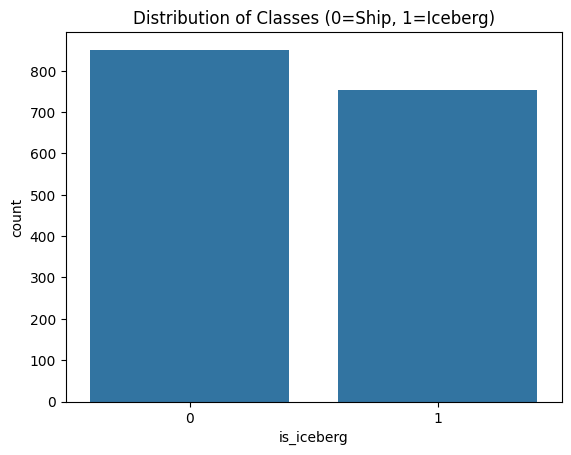

is_iceberg
0    53.054863
1    46.945137
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Icebergs vs Ships
sns.countplot(x="is_iceberg", data=train)
plt.title("Distribution of Classes (0=Ship, 1=Iceberg)")
plt.show()

# Check class percentages
print(train['is_iceberg'].value_counts(normalize=True) * 100)

checking for missing values

Missing incidence angles: 133


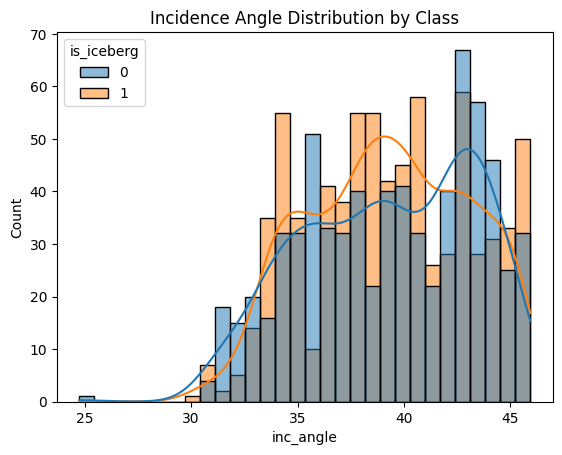

In [ ]:
# Convert inc_angle to numeric, coerce 'na' to NaN
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce')

# Check missing values in incidence angle
print("Missing incidence angles:", train['inc_angle'].isnull().sum())

# Plot incidence angle distribution by class
sns.histplot(data=train, x='inc_angle', hue='is_iceberg', bins=30, kde=True)
plt.title("Incidence Angle Distribution by Class")
plt.show()

Statistical exploration

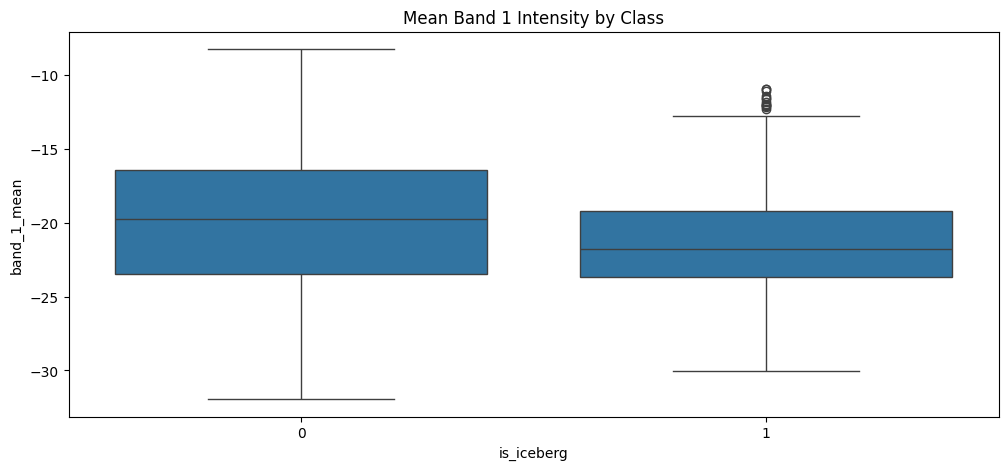

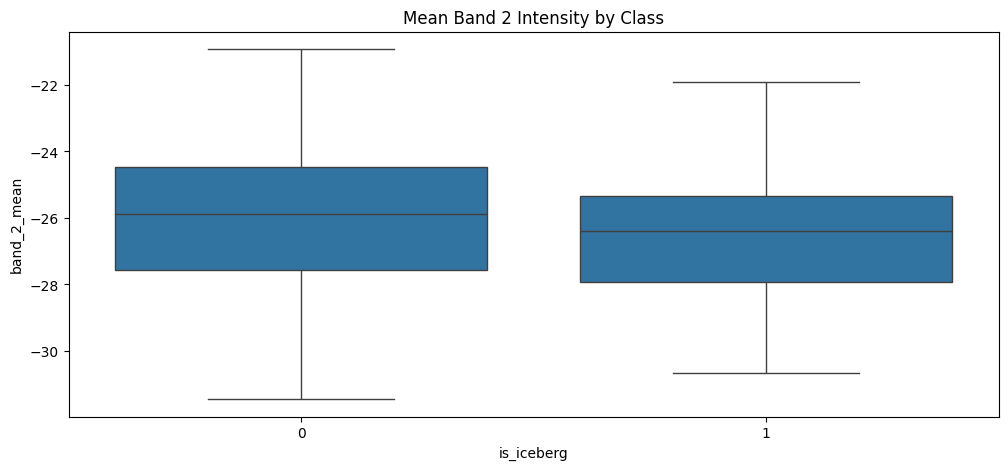

In [ ]:
import numpy as np

# Convert band_1 and band_2 from lists to arrays
train['band_1_array'] = train['band_1'].apply(lambda x: np.array(x).reshape(75,75))
train['band_2_array'] = train['band_2'].apply(lambda x: np.array(x).reshape(75,75))

# Check mean intensity per image
train['band_1_mean'] = train['band_1_array'].apply(np.mean)
train['band_2_mean'] = train['band_2_array'].apply(np.mean)

# Plot mean intensity by class
plt.figure(figsize=(12,5))
sns.boxplot(x='is_iceberg', y='band_1_mean', data=train)
plt.title("Mean Band 1 Intensity by Class")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='is_iceberg', y='band_2_mean', data=train)
plt.title("Mean Band 2 Intensity by Class")
plt.show()

**Visualize a few images**

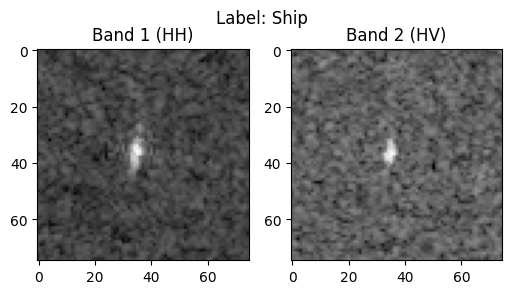

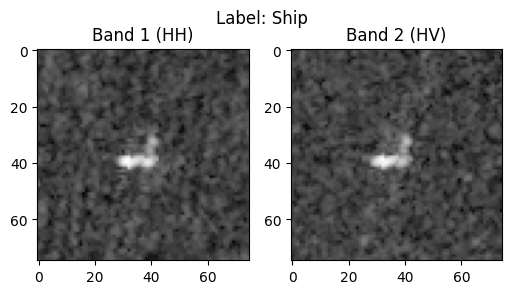

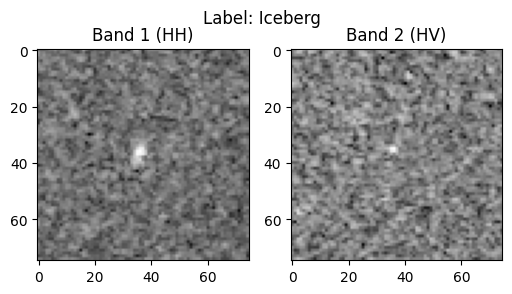

In [ ]:
def plot_image(row):
    band1 = row['band_1_array']
    band2 = row['band_2_array']

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(band1, cmap='gray')
    plt.title('Band 1 (HH)')
    plt.subplot(1,2,2)
    plt.imshow(band2, cmap='gray')
    plt.title('Band 2 (HV)')
    plt.suptitle(f"Label: {'Iceberg' if row['is_iceberg']==1 else 'Ship'}")
    plt.show()

# Plot first 3 images
for i in range(3):
    plot_image(train.iloc[i])

***Handle Missing Values (Preprocessing)***

In [ ]:
# --- Step 1: Impute missing inc_angle with mean ---
mean_angle = train['inc_angle'].mean()
train['inc_angle'] = train['inc_angle'].fillna(mean_angle)

# --- Step 2: Normalize inc_angle to 0-1 ---
train['inc_angle_norm'] = train['inc_angle'] / train['inc_angle'].max()

# --- Step 3: Convert bands to numpy arrays and normalize ---
train['band_1_array'] = train['band_1'].apply(lambda x: np.array(x).reshape(75,75))
train['band_2_array'] = train['band_2'].apply(lambda x: np.array(x).reshape(75,75))

# Normalize each image by its max absolute value (helps NN training)
train['band_1_norm'] = train['band_1_array'].apply(lambda x: x / np.abs(x).max())
train['band_2_norm'] = train['band_2_array'].apply(lambda x: x / np.abs(x).max())

# --- Step 4: Prepare final feature array for neural network ---
# Stack band_1, band_2, and normalized incidence angle as 3 channels
X_train = np.stack([
    np.stack(train['band_1_norm'].values),
    np.stack(train['band_2_norm'].values),
    np.full((train.shape[0], 75, 75), train['inc_angle_norm'].values[:, None, None])
], axis=-1)

Y_train = train['is_iceberg'].values

print("X_train shape:", X_train.shape)  # (num_samples, 75, 75, 3)
print("Y_train shape:", Y_train.shape)

X_train shape: (1604, 75, 75, 3)
Y_train shape: (1604,)


**Normalizing the test dataset features**

In [ ]:
# --- Load test data ---
test = pd.read_json("/content/iceberg_data/data/processed/test.json")

# --- Step 1: Convert 'na' to NaN for inc_angle ---
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

# --- Step 2: Impute missing inc_angle using training mean ---
test['inc_angle_missing'] = test['inc_angle'].isnull().astype(int)  # mark missing first
test['inc_angle'] = test['inc_angle'].fillna(mean_angle)  # safe assignment

# --- Step 3: Normalize inc_angle ---
test['inc_angle_norm'] = test['inc_angle'] / train['inc_angle'].max()  # use training max

# --- Step 4: Convert bands to numpy arrays and normalize ---
test['band_1_array'] = test['band_1'].apply(lambda x: np.array(x).reshape(75,75))
test['band_2_array'] = test['band_2'].apply(lambda x: np.array(x).reshape(75,75))

test['band_1_norm'] = test['band_1_array'].apply(lambda x: x / np.abs(x).max())
test['band_2_norm'] = test['band_2_array'].apply(lambda x: x / np.abs(x).max())

# --- Step 5: Stack features into 3-channel array ---
X_test = np.stack([
    np.stack(test['band_1_norm'].values),
    np.stack(test['band_2_norm'].values),
    np.full((test.shape[0], 75, 75), test['inc_angle_norm'].values[:, None, None])
], axis=-1)

print("X_test shape:", X_test.shape)  # (num_samples, 75, 75, 3)

X_test shape: (8424, 75, 75, 3)


# **Feeding Data to Model**

**Import necessary libraries**

In [ ]:
#Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

**Create PyTorch Dataset**

In [ ]:
class IcebergDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0,3,1,2)  # to (N, C, H, W)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

#  Train/Validation Split

In [ ]:
dataset = IcebergDataset(X_train, Y_train)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

**Define Simple CNN**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class PretrainedCNN(nn.Module):
    def __init__(self, pretrained=True):
        super(PretrainedCNN, self).__init__()
        # Load pretrained ResNet18
        self.model = models.resnet18(pretrained=pretrained)

        # Replace the final fully connected layer
        # ResNet18 has 512 features in the last layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

**Train the CNN**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 256MB/s]



BASELINE CNN TRAINING - WITH EVALUATION METRICS

Epoch 1/10
  Train Loss: 0.4148
  Val Loss:   1.1322
  Val Acc:    0.6929
  Val Prec:   0.5994
  Val Recall: 0.9772
  Val F1:     0.7431
----------------------------------------------------------------------
Epoch 2/10
  Train Loss: 0.2782
  Val Loss:   0.3021
  Val Acc:    0.8900
  Val Prec:   0.8990
  Val Recall: 0.8539
  Val F1:     0.8759
----------------------------------------------------------------------
Epoch 3/10
  Train Loss: 0.1800
  Val Loss:   0.5139
  Val Acc:    0.8237
  Val Prec:   0.9589
  Val Recall: 0.6393
  Val F1:     0.7671
----------------------------------------------------------------------
Epoch 4/10
  Train Loss: 0.1542
  Val Loss:   0.4038
  Val Acc:    0.8402
  Val Prec:   0.8777
  Val Recall: 0.7534
  Val F1:     0.8108
----------------------------------------------------------------------
Epoch 5/10
  Train Loss: 0.2396
  Val Loss:   0.3461
  Val Acc:    0.8506
  Val Prec:   0.8075
  Val Recall: 0.8813
  

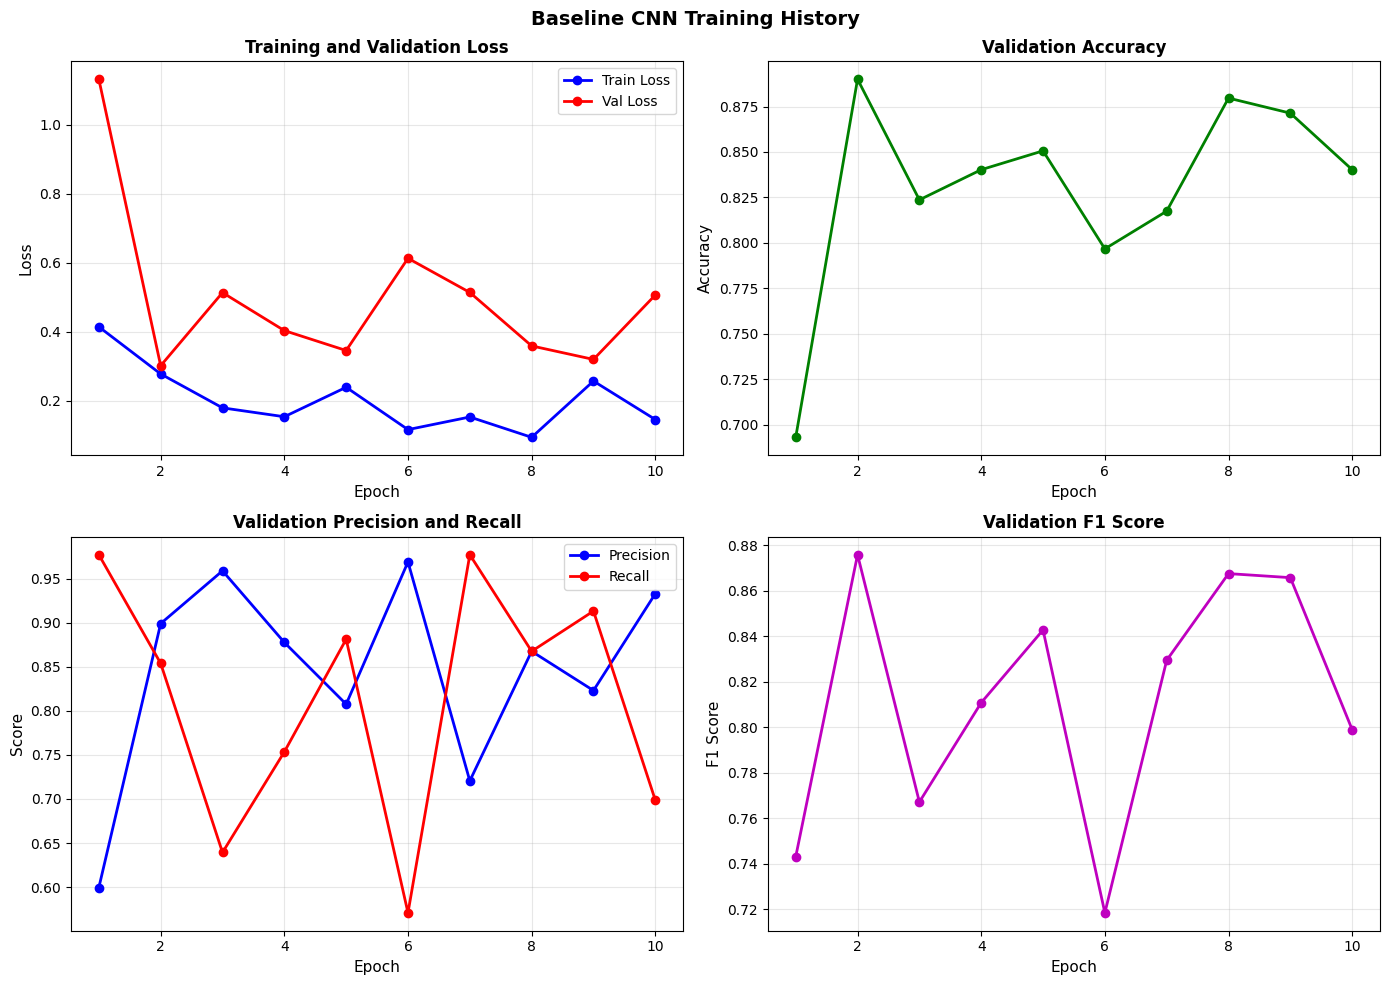


FINAL VALIDATION SET EVALUATION

Final Validation Metrics:
  Accuracy:  0.8402
  Precision: 0.9329
  Recall:    0.6986
  F1 Score:  0.7990

Detailed Classification Report:
              precision    recall  f1-score   support

        Ship     0.7925    0.9582    0.8675       263
     Iceberg     0.9329    0.6986    0.7990       219

    accuracy                         0.8402       482
   macro avg     0.8627    0.8284    0.8332       482
weighted avg     0.8563    0.8402    0.8363       482


Saved: baseline_validation_confusion_matrix.png


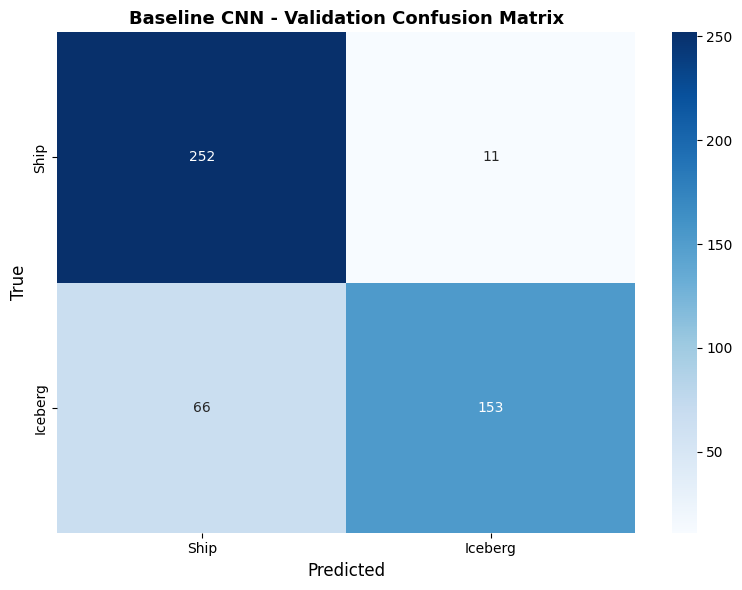


Saved: baseline_cnn_results.json

📋 COPY THESE VALUES TO MILESTONE 3 COMPARISON SCRIPT:

BASELINE_RESULTS = {
    'precision': 0.9329,
    'recall':    0.6986,
    'f1':        0.7990,
    'accuracy':  0.8402
}



In [ ]:
"""
Baseline CNN Model Training with Evaluation Metrics
Updated to include precision, recall, F1 score tracking during training and final evaluation.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json

# ============================================================================
# TRAINING WITH METRICS
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PretrainedCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

print("\n" + "="*70)
print("BASELINE CNN TRAINING - WITH EVALUATION METRICS")
print("="*70 + "\n")

for epoch in range(epochs):
    # ========================
    # TRAINING PHASE
    # ========================
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # shape (batch,1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # ========================
    # VALIDATION PHASE
    # ========================
    model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)

            # Calculate validation loss
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

            # Get predictions
            preds = (outputs > 0.5).float()

            # Store for metrics calculation
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, zero_division=0)
    val_recall = recall_score(all_labels, all_preds, zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {epoch_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Acc:    {val_acc:.4f}")
    print(f"  Val Prec:   {val_precision:.4f}")
    print(f"  Val Recall: {val_recall:.4f}")
    print(f"  Val F1:     {val_f1:.4f}")
    print("-" * 70)

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70 + "\n")

# ============================================================================
# PLOT TRAINING HISTORY
# ============================================================================

def plot_training_history():
    """Plot training and validation metrics over epochs."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    epochs_range = range(1, epochs + 1)

    # Loss plot
    axes[0, 0].plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs_range, val_losses, 'r-o', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(epochs_range, val_accuracies, 'g-o', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Accuracy', fontsize=11)
    axes[0, 1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Precision and Recall plot
    axes[1, 0].plot(epochs_range, val_precisions, 'b-o', label='Precision', linewidth=2)
    axes[1, 0].plot(epochs_range, val_recalls, 'r-o', label='Recall', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Score', fontsize=11)
    axes[1, 0].set_title('Validation Precision and Recall', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # F1 Score plot
    axes[1, 1].plot(epochs_range, val_f1_scores, 'm-o', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('F1 Score', fontsize=11)
    axes[1, 1].set_title('Validation F1 Score', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Baseline CNN Training History', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('baseline_training_history.png', dpi=300, bbox_inches='tight')
    print("Saved: baseline_training_history.png")
    plt.show()

plot_training_history()

# ============================================================================
# FINAL VALIDATION SET EVALUATION
# ============================================================================

print("\n" + "="*70)
print("FINAL VALIDATION SET EVALUATION")
print("="*70 + "\n")

model.eval()
all_val_preds = []
all_val_labels = []
all_val_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_val_preds.extend(preds.cpu().numpy().flatten())
        all_val_labels.extend(labels.cpu().numpy().flatten())
        all_val_probs.extend(outputs.cpu().numpy().flatten())

# Convert to numpy
all_val_preds = np.array(all_val_preds)
all_val_labels = np.array(all_val_labels)
all_val_probs = np.array(all_val_probs)

# Calculate final metrics
final_val_accuracy = accuracy_score(all_val_labels, all_val_preds)
final_val_precision = precision_score(all_val_labels, all_val_preds)
final_val_recall = recall_score(all_val_labels, all_val_preds)
final_val_f1 = f1_score(all_val_labels, all_val_preds)

print("Final Validation Metrics:")
print(f"  Accuracy:  {final_val_accuracy:.4f}")
print(f"  Precision: {final_val_precision:.4f}")
print(f"  Recall:    {final_val_recall:.4f}")
print(f"  F1 Score:  {final_val_f1:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(all_val_labels, all_val_preds,
                          target_names=['Ship', 'Iceberg'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Ship', 'Iceberg'],
           yticklabels=['Ship', 'Iceberg'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Baseline CNN - Validation Confusion Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('baseline_validation_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nSaved: baseline_validation_confusion_matrix.png")
plt.show()

# ============================================================================
# SAVE BASELINE RESULTS FOR MILESTONE 3 COMPARISON
# ============================================================================

baseline_results = {
    'final_validation': {
        'accuracy': float(final_val_accuracy),
        'precision': float(final_val_precision),
        'recall': float(final_val_recall),
        'f1': float(final_val_f1)
    },
    'training_history': {
        'train_losses': [float(x) for x in train_losses],
        'val_losses': [float(x) for x in val_losses],
        'val_accuracies': [float(x) for x in val_accuracies],
        'val_precisions': [float(x) for x in val_precisions],
        'val_recalls': [float(x) for x in val_recalls],
        'val_f1_scores': [float(x) for x in val_f1_scores]
    }
}

# Save to JSON
with open('baseline_cnn_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=4)
print("\nSaved: baseline_cnn_results.json")

# Print summary for easy copying to Milestone 3 comparison
print("\n" + "="*70)
print("📋 COPY THESE VALUES TO MILESTONE 3 COMPARISON SCRIPT:")
print("="*70)
print("\nBASELINE_RESULTS = {")
print(f"    'precision': {final_val_precision:.4f},")
print(f"    'recall':    {final_val_recall:.4f},")
print(f"    'f1':        {final_val_f1:.4f},")
print(f"    'accuracy':  {final_val_accuracy:.4f}")
print("}")
print("="*70 + "\n")

**Testing model's performance on test set**


BASELINE CNN - TEST SET PREDICTION

Generating test predictions...
✅ Saved: baseline_submission.csv

Prediction Statistics:
  Total samples: 8424
  Mean probability: 0.2669
  Std probability: 0.3367
  Min probability: 0.0000
  Max probability: 0.9996
  Predicted icebergs (>0.5): 1899 (22.5%)
  Predicted ships (≤0.5): 6525 (77.5%)

ℹ️  NO TEST LABELS AVAILABLE

Test predictions have been saved to 'baseline_submission.csv'
for Kaggle submission.

If you get test labels later:
  1. Set HAS_TEST_LABELS = True in this script
  2. Uncomment and set test_labels variable
  3. Re-run this cell

For Milestone 3 comparison, you can use VALIDATION metrics
from the training script as a proxy for test performance.


PREDICTION DISTRIBUTION ANALYSIS

Saved: baseline_prediction_distribution.png


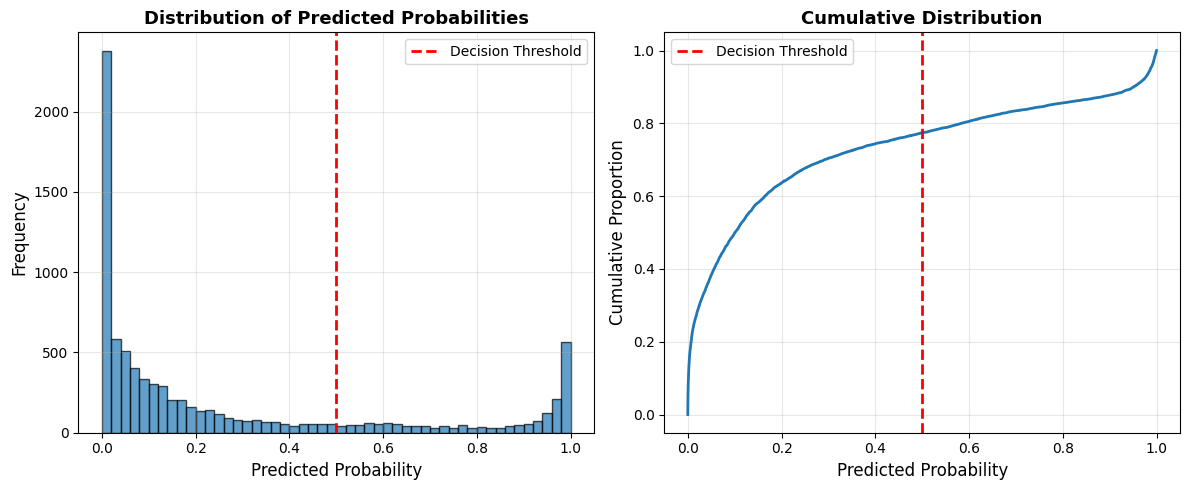


Prediction Confidence Analysis:
  Very confident iceberg (>0.8): 1214 (14.4%)
  Confident iceberg (0.6-0.8): 429 (5.1%)
  Uncertain (0.4-0.6): 514 (6.1%)
  Confident ship (0.2-0.4): 906 (10.8%)
  Very confident ship (<0.2): 5361 (63.6%)

✅ TEST SET EVALUATION COMPLETE!


In [ ]:
"""
Baseline CNN Test Set Evaluation
Generates predictions for test set and calculates metrics if labels are available.
"""

import pandas as pd
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (precision_score, recall_score, f1_score,
                            accuracy_score, confusion_matrix, classification_report,
                            roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import json

# ============================================================================
# TEST SET PREDICTION (WITHOUT LABELS - FOR KAGGLE SUBMISSION)
# ============================================================================

print("\n" + "="*70)
print("BASELINE CNN - TEST SET PREDICTION")
print("="*70 + "\n")

# Convert to tensor and create DataLoader
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Generate predictions
model.eval()
all_preds = []

print("Generating test predictions...")
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        all_preds.append(outputs.cpu())

# Concatenate all batches
test_probs = torch.cat(all_preds, dim=0).numpy().flatten()

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'is_iceberg': test_probs
})

submission.to_csv("baseline_submission.csv", index=False)
print("✅ Saved: baseline_submission.csv")

# Print statistics
print(f"\nPrediction Statistics:")
print(f"  Total samples: {len(test_probs)}")
print(f"  Mean probability: {test_probs.mean():.4f}")
print(f"  Std probability: {test_probs.std():.4f}")
print(f"  Min probability: {test_probs.min():.4f}")
print(f"  Max probability: {test_probs.max():.4f}")
print(f"  Predicted icebergs (>0.5): {(test_probs > 0.5).sum()} ({(test_probs > 0.5).mean()*100:.1f}%)")
print(f"  Predicted ships (≤0.5): {(test_probs <= 0.5).sum()} ({(test_probs <= 0.5).mean()*100:.1f}%)")

# ============================================================================
# TEST SET EVALUATION (IF YOU HAVE TEST LABELS)
# ============================================================================

# Check if test labels are available
HAS_TEST_LABELS = False  # Set to True if you have test labels

# If you have test labels, uncomment and update this:
# test_labels = your_test_labels_array  # Should be numpy array or list of 0s and 1s
# HAS_TEST_LABELS = True

if HAS_TEST_LABELS:
    print("\n" + "="*70)
    print("BASELINE CNN - TEST SET EVALUATION (WITH LABELS)")
    print("="*70 + "\n")

    # Convert labels to numpy if needed
    test_labels = np.array(test_labels)

    # Get binary predictions
    test_preds = (test_probs > 0.5).astype(int)

    # Calculate metrics
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)
    test_auc = roc_auc_score(test_labels, test_probs)

    print("Test Set Metrics:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1 Score:  {test_f1:.4f}")
    print(f"  AUC-ROC:   {test_auc:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(test_labels, test_preds,
                              target_names=['Ship', 'Iceberg'],
                              digits=4))

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Ship', 'Iceberg'],
               yticklabels=['Ship', 'Iceberg'])
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Baseline CNN - Test Set Confusion Matrix', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('baseline_test_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\nSaved: baseline_test_confusion_matrix.png")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'Baseline CNN (AUC = {test_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Baseline CNN - ROC Curve', fontsize=13, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('baseline_test_roc_curve.png', dpi=300, bbox_inches='tight')
    print("Saved: baseline_test_roc_curve.png")
    plt.show()

    # Save test results
    test_results = {
        'test_metrics': {
            'accuracy': float(test_accuracy),
            'precision': float(test_precision),
            'recall': float(test_recall),
            'f1': float(test_f1),
            'auc': float(test_auc)
        },
        'confusion_matrix': cm.tolist()
    }

    with open('baseline_test_results.json', 'w') as f:
        json.dump(test_results, f, indent=4)
    print("\nSaved: baseline_test_results.json")

    # Print for Milestone 3 comparison
    print("\n" + "="*70)
    print("📋 COPY THESE TEST VALUES TO MILESTONE 3 COMPARISON SCRIPT:")
    print("="*70)
    print("\nBASELINE_RESULTS = {")
    print(f"    'precision': {test_precision:.4f},")
    print(f"    'recall':    {test_recall:.4f},")
    print(f"    'f1':        {test_f1:.4f},")
    print(f"    'accuracy':  {test_accuracy:.4f}")
    print("}")
    print("="*70 + "\n")

else:
    print("\n" + "="*70)
    print("ℹ️  NO TEST LABELS AVAILABLE")
    print("="*70)
    print("\nTest predictions have been saved to 'baseline_submission.csv'")
    print("for Kaggle submission.")
    print("\nIf you get test labels later:")
    print("  1. Set HAS_TEST_LABELS = True in this script")
    print("  2. Uncomment and set test_labels variable")
    print("  3. Re-run this cell")
    print("\nFor Milestone 3 comparison, you can use VALIDATION metrics")
    print("from the training script as a proxy for test performance.")
    print("="*70 + "\n")

# ============================================================================
# PREDICTION DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("="*70 + "\n")

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(test_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Predicted Probabilities', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Cumulative distribution
plt.subplot(1, 2, 2)
sorted_probs = np.sort(test_probs)
cumulative = np.arange(1, len(sorted_probs) + 1) / len(sorted_probs)
plt.plot(sorted_probs, cumulative, linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Cumulative Proportion', fontsize=12)
plt.title('Cumulative Distribution', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_prediction_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: baseline_prediction_distribution.png")
plt.show()

# Analyze predictions by confidence
print("\nPrediction Confidence Analysis:")
very_confident_iceberg = (test_probs > 0.8).sum()
confident_iceberg = ((test_probs > 0.6) & (test_probs <= 0.8)).sum()
uncertain = ((test_probs >= 0.4) & (test_probs <= 0.6)).sum()
confident_ship = ((test_probs >= 0.2) & (test_probs < 0.4)).sum()
very_confident_ship = (test_probs < 0.2).sum()

print(f"  Very confident iceberg (>0.8): {very_confident_iceberg} ({very_confident_iceberg/len(test_probs)*100:.1f}%)")
print(f"  Confident iceberg (0.6-0.8): {confident_iceberg} ({confident_iceberg/len(test_probs)*100:.1f}%)")
print(f"  Uncertain (0.4-0.6): {uncertain} ({uncertain/len(test_probs)*100:.1f}%)")
print(f"  Confident ship (0.2-0.4): {confident_ship} ({confident_ship/len(test_probs)*100:.1f}%)")
print(f"  Very confident ship (<0.2): {very_confident_ship} ({very_confident_ship/len(test_probs)*100:.1f}%)")

print("\n" + "="*70)
print("✅ TEST SET EVALUATION COMPLETE!")
print("="*70)